# Cleaning and PCA

In [1]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from itertools import combinations

In [2]:
data = pd.read_csv('/workspaces/wiggle-face/data/panda_each_video/all_panda_features_updated.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285001 entries, 0 to 1285000
Data columns (total 34 columns):
 #   Column                                                Non-Null Count    Dtype  
---  ------                                                --------------    -----  
 0   infant_id                                             1285001 non-null  int64  
 1   date                                                  448436 non-null   float64
 2   cam                                                   448436 non-null   float64
 3   frame_id                                              1285001 non-null  int64  
 4   right_brow_mean_y                                     1285001 non-null  float64
 5   left_brow_mean_y                                      1285001 non-null  float64
 6   right_eye_distance                                    1285001 non-null  float64
 7   left_eye_distance                                     1285001 non-null  float64
 8   lips_distance                   

In [3]:
def remove_outliers(column):
    mean = column.mean()
    std = column.std()
    return column[(column >= mean - 3 * std) & (column <= mean + 3 * std)]

conditions = (
    (data['right_brow_mean_y'] >= 0.4) & (data['left_brow_mean_y'] >= 0.4) 
 )
eye_width_condition = abs(data['right_eye_width'] - data['left_eye_width']) <= 0.1
eyebrow_width_condition = abs(data['right_eyebrow_width'] - data['left_eyebrow_width']) <= 0.2

# Account for head rotation
data = data[eye_width_condition & eyebrow_width_condition &  conditions]
data = data.apply(remove_outliers)

data = data.reset_index(drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503629 entries, 0 to 503628
Data columns (total 34 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   infant_id                                             489603 non-null  float64
 1   date                                                  133815 non-null  float64
 2   cam                                                   133815 non-null  float64
 3   frame_id                                              497359 non-null  float64
 4   right_brow_mean_y                                     503629 non-null  float64
 5   left_brow_mean_y                                      503629 non-null  float64
 6   right_eye_distance                                    495366 non-null  float64
 7   left_eye_distance                                     496246 non-null  float64
 8   lips_distance                               

In [4]:
features = data.drop(columns=['infant_id', 'frame_id','date', 'cam', 'age'])
features

,right_brow_mean_y,left_brow_mean_y,right_eye_distance,left_eye_distance,lips_distance,left_eye_width,right_eye_width,left_eyebrow_width,right_eyebrow_width,lip_width,...,curvature_upper_left_brow,curvature_lower_left_brow,curvature_upper_left_eyelid,curvature_lower_left_eyelid,curvature_upper_right_eyelid,curvature_lower_right_eyelid,curvature_upper_outer_lip,curvature_lower_outer_lip,curvature_upper_inner_lip,curvature_lower_inner_lip
0,0.578312,0.522265,0.175088,0.183976,0.008589,0.507032,0.428829,0.749188,0.564868,0.660066,...,1.117268,0.596946,2.463687,1.154410,3.009045,1.542399,1.770518,2.239342,0.686738,0.027549
1,0.901760,0.843465,0.175058,0.185739,0.012644,0.506678,0.430091,0.752716,0.589096,0.670905,...,1.188671,0.636778,2.426133,1.263844,3.026428,1.562662,1.651708,1.932361,0.709494,0.245691
2,0.904089,0.851144,0.171311,0.181891,0.012543,0.508100,0.432293,0.745538,0.589904,0.664504,...,1.144263,0.631421,2.348470,1.275923,2.876486,1.577599,1.705647,1.991199,0.798197,0.028191
3,0.904192,0.868161,0.168297,0.178532,0.010381,0.498225,0.436430,0.754410,0.603837,0.679178,...,1.144648,0.562679,2.462608,1.345827,2.864451,1.588496,1.589688,1.925304,0.691536,0.021022
4,0.905433,0.889612,0.169986,0.175811,0.014533,0.490042,0.435499,0.741015,0.612841,0.658556,...,1.143823,0.677388,2.440670,1.193029,2.818799,1.686506,1.631812,2.473867,0.681219,0.028492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503624,0.855153,0.913840,0.100185,0.100880,0.071267,0.438075,0.501575,0.647658,0.774488,0.833815,...,1.260172,0.479811,2.324102,1.052985,1.810921,0.828961,1.655888,2.142543,0.742374,0.037999
503625,0.854011,0.913481,0.088770,0.095622,0.057389,0.431408,0.498334,0.622322,0.784381,0.803948,...,1.298232,0.561585,2.120950,1.064636,1.640011,0.651165,1.755654,2.401272,0.702675,0.058855
503626,0.410050,0.495677,0.094413,0.101154,0.067340,0.433002,0.510454,0.607091,0.792158,0.802436,...,1.339576,0.544635,2.361292,0.985204,1.696027,0.801209,1.819878,2.364879,0.775678,0.081084
503627,0.817609,0.918534,0.036804,0.053795,0.007079,0.441644,0.524365,0.611447,0.760014,0.855597,...,1.124091,0.442024,1.068734,0.561111,NaN,0.527072,1.131441,2.202350,0.151430,0.000006


In [5]:
missing_indices = features[features.isna().any(axis=1)].index

# Drop these rows from both features and data
features.dropna(inplace=True)
features = features.reset_index(drop=True)
data.drop(index=missing_indices, inplace=True)
data = data.reset_index(drop=True)

features

,right_brow_mean_y,left_brow_mean_y,right_eye_distance,left_eye_distance,lips_distance,left_eye_width,right_eye_width,left_eyebrow_width,right_eyebrow_width,lip_width,...,curvature_upper_left_brow,curvature_lower_left_brow,curvature_upper_left_eyelid,curvature_lower_left_eyelid,curvature_upper_right_eyelid,curvature_lower_right_eyelid,curvature_upper_outer_lip,curvature_lower_outer_lip,curvature_upper_inner_lip,curvature_lower_inner_lip
0,0.578312,0.522265,0.175088,0.183976,0.008589,0.507032,0.428829,0.749188,0.564868,0.660066,...,1.117268,0.596946,2.463687,1.154410,3.009045,1.542399,1.770518,2.239342,0.686738,0.027549
1,0.901760,0.843465,0.175058,0.185739,0.012644,0.506678,0.430091,0.752716,0.589096,0.670905,...,1.188671,0.636778,2.426133,1.263844,3.026428,1.562662,1.651708,1.932361,0.709494,0.245691
2,0.904089,0.851144,0.171311,0.181891,0.012543,0.508100,0.432293,0.745538,0.589904,0.664504,...,1.144263,0.631421,2.348470,1.275923,2.876486,1.577599,1.705647,1.991199,0.798197,0.028191
3,0.904192,0.868161,0.168297,0.178532,0.010381,0.498225,0.436430,0.754410,0.603837,0.679178,...,1.144648,0.562679,2.462608,1.345827,2.864451,1.588496,1.589688,1.925304,0.691536,0.021022
4,0.905433,0.889612,0.169986,0.175811,0.014533,0.490042,0.435499,0.741015,0.612841,0.658556,...,1.143823,0.677388,2.440670,1.193029,2.818799,1.686506,1.631812,2.473867,0.681219,0.028492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451523,0.867385,0.910657,0.090284,0.096727,0.038309,0.423761,0.487104,0.605050,0.742010,0.814588,...,1.470873,0.685606,2.330060,0.747522,1.721391,1.064619,1.486834,2.484279,0.525853,0.047274
451524,0.848193,0.913853,0.100685,0.102096,0.081462,0.429777,0.499511,0.659189,0.765695,0.834792,...,1.179181,0.527772,2.508937,0.973699,1.833898,0.587129,1.626692,2.017898,0.670633,0.111385
451525,0.855153,0.913840,0.100185,0.100880,0.071267,0.438075,0.501575,0.647658,0.774488,0.833815,...,1.260172,0.479811,2.324102,1.052985,1.810921,0.828961,1.655888,2.142543,0.742374,0.037999
451526,0.854011,0.913481,0.088770,0.095622,0.057389,0.431408,0.498334,0.622322,0.784381,0.803948,...,1.298232,0.561585,2.120950,1.064636,1.640011,0.651165,1.755654,2.401272,0.702675,0.058855


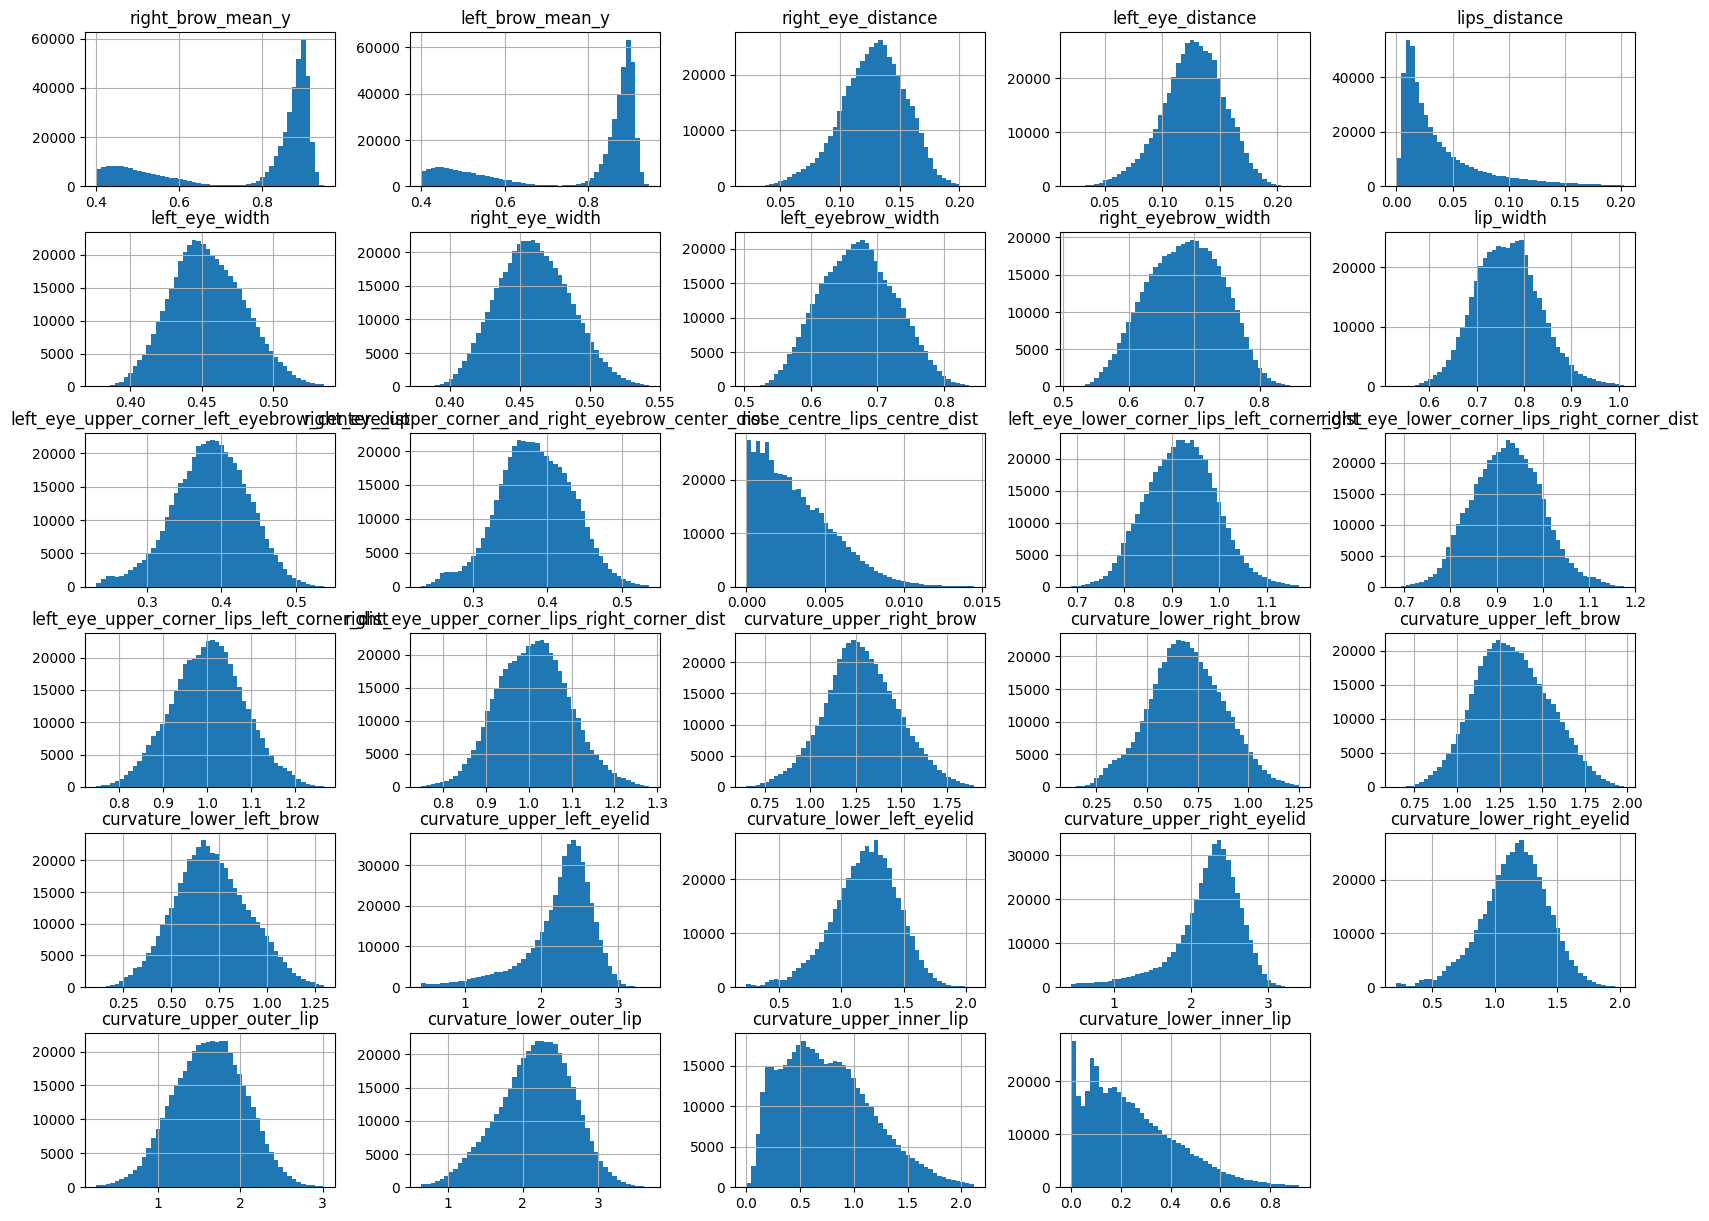

In [6]:
features.hist(bins=50, figsize=(20, 15))
plt.show()

In [7]:
data.drop(columns=['nose_centre_lips_centre_dist'], inplace=True)
features.drop(columns=['nose_centre_lips_centre_dist'], inplace=True)

data.drop(columns=['left_eye_width','right_eye_width','left_eyebrow_width','right_eyebrow_width', 'left_brow_mean_y', 'right_brow_mean_y'], inplace=True)
features.drop(columns=['left_eye_width','right_eye_width','left_eyebrow_width','right_eyebrow_width', 'left_brow_mean_y', 'right_brow_mean_y'], inplace=True)

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451528 entries, 0 to 451527
Data columns (total 22 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   right_eye_distance                                    451528 non-null  float64
 1   left_eye_distance                                     451528 non-null  float64
 2   lips_distance                                         451528 non-null  float64
 3   lip_width                                             451528 non-null  float64
 4   left_eye_upper_corner_left_eyebrow_center_dist        451528 non-null  float64
 5   right_eye_upper_corner_and_right_eyebrow_center_dist  451528 non-null  float64
 6   left_eye_lower_corner_lips_left_corner_dist           451528 non-null  float64
 7   right_eye_lower_corner_lips_right_corner_dist         451528 non-null  float64
 8   left_eye_upper_corner_lips_left_corner_dist 

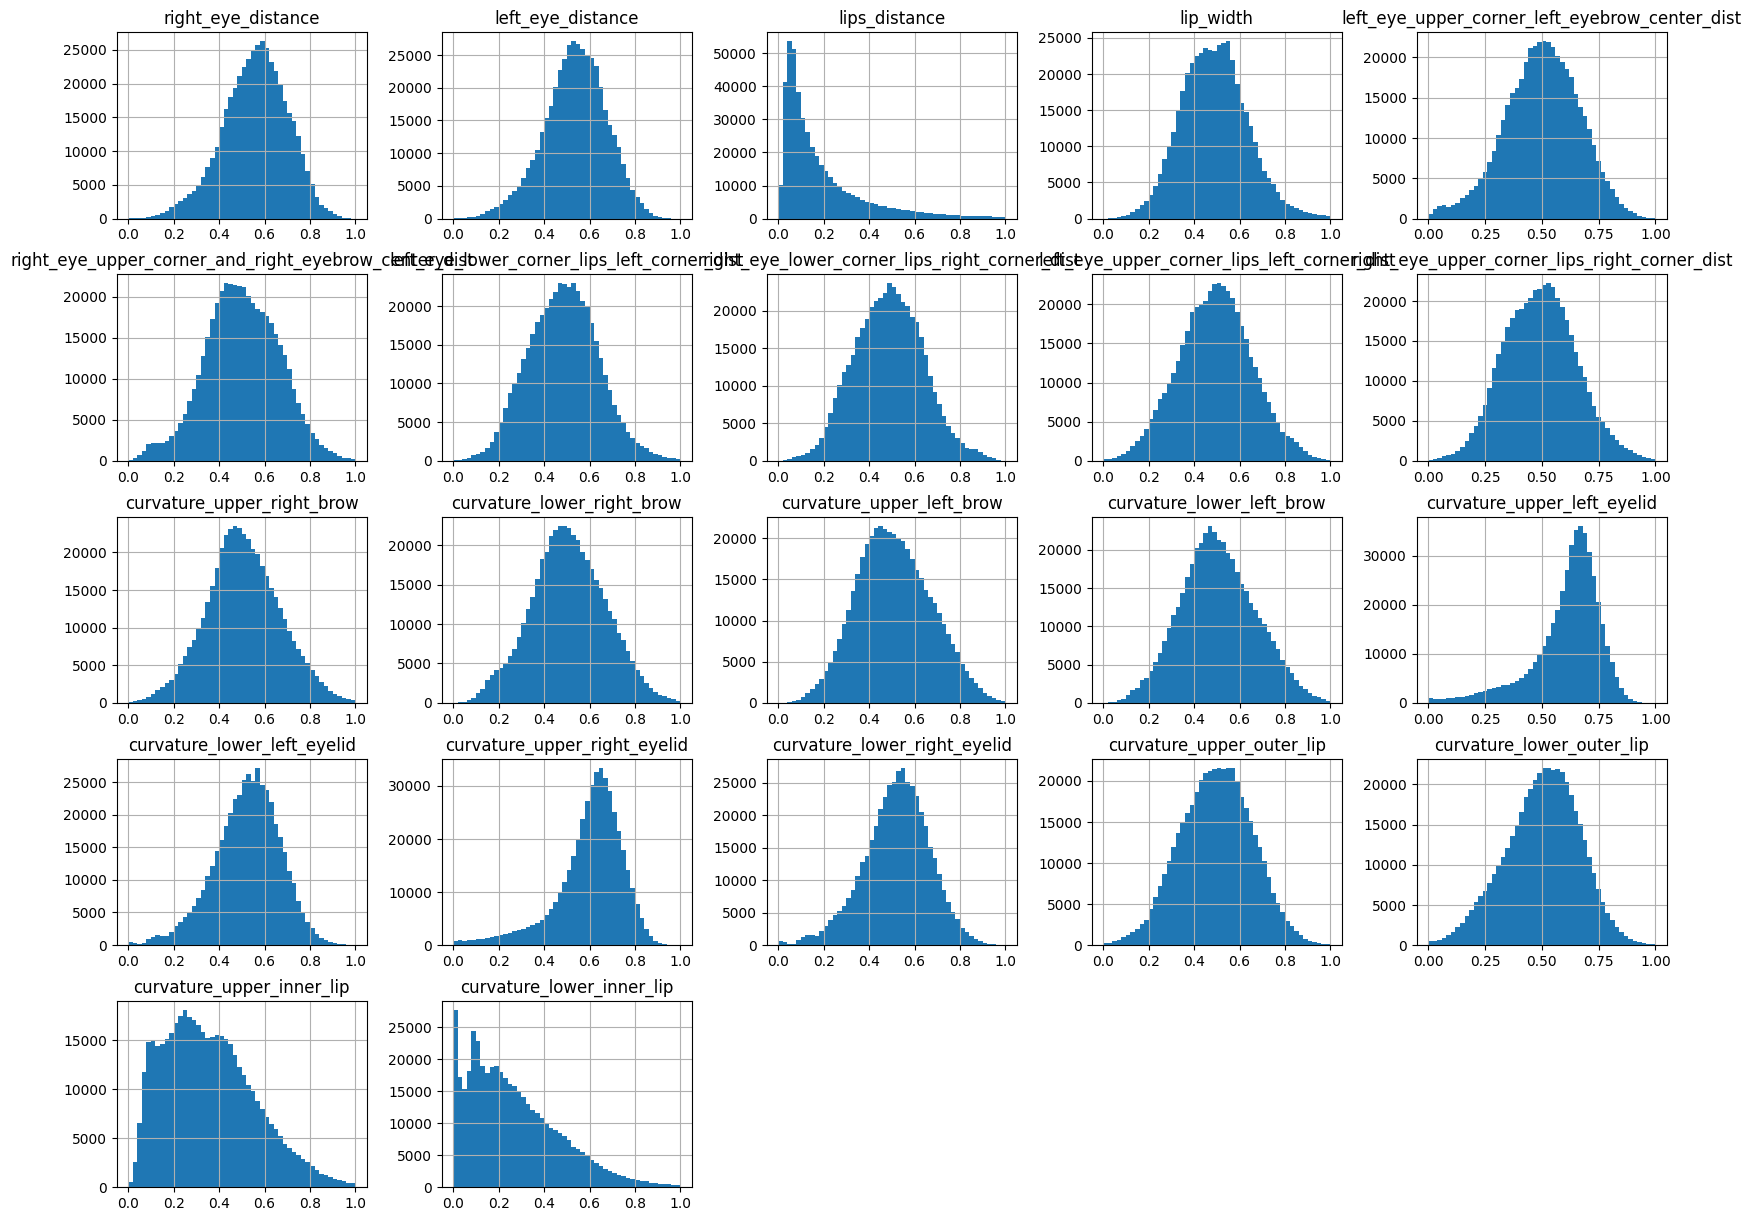

In [9]:
scaler = MinMaxScaler()

# Scale all columns using MinMaxScaler
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

# Optionally, plot the scaled features to see the distribution
features_scaled.hist(bins=50, figsize=(20, 15))
plt.show()

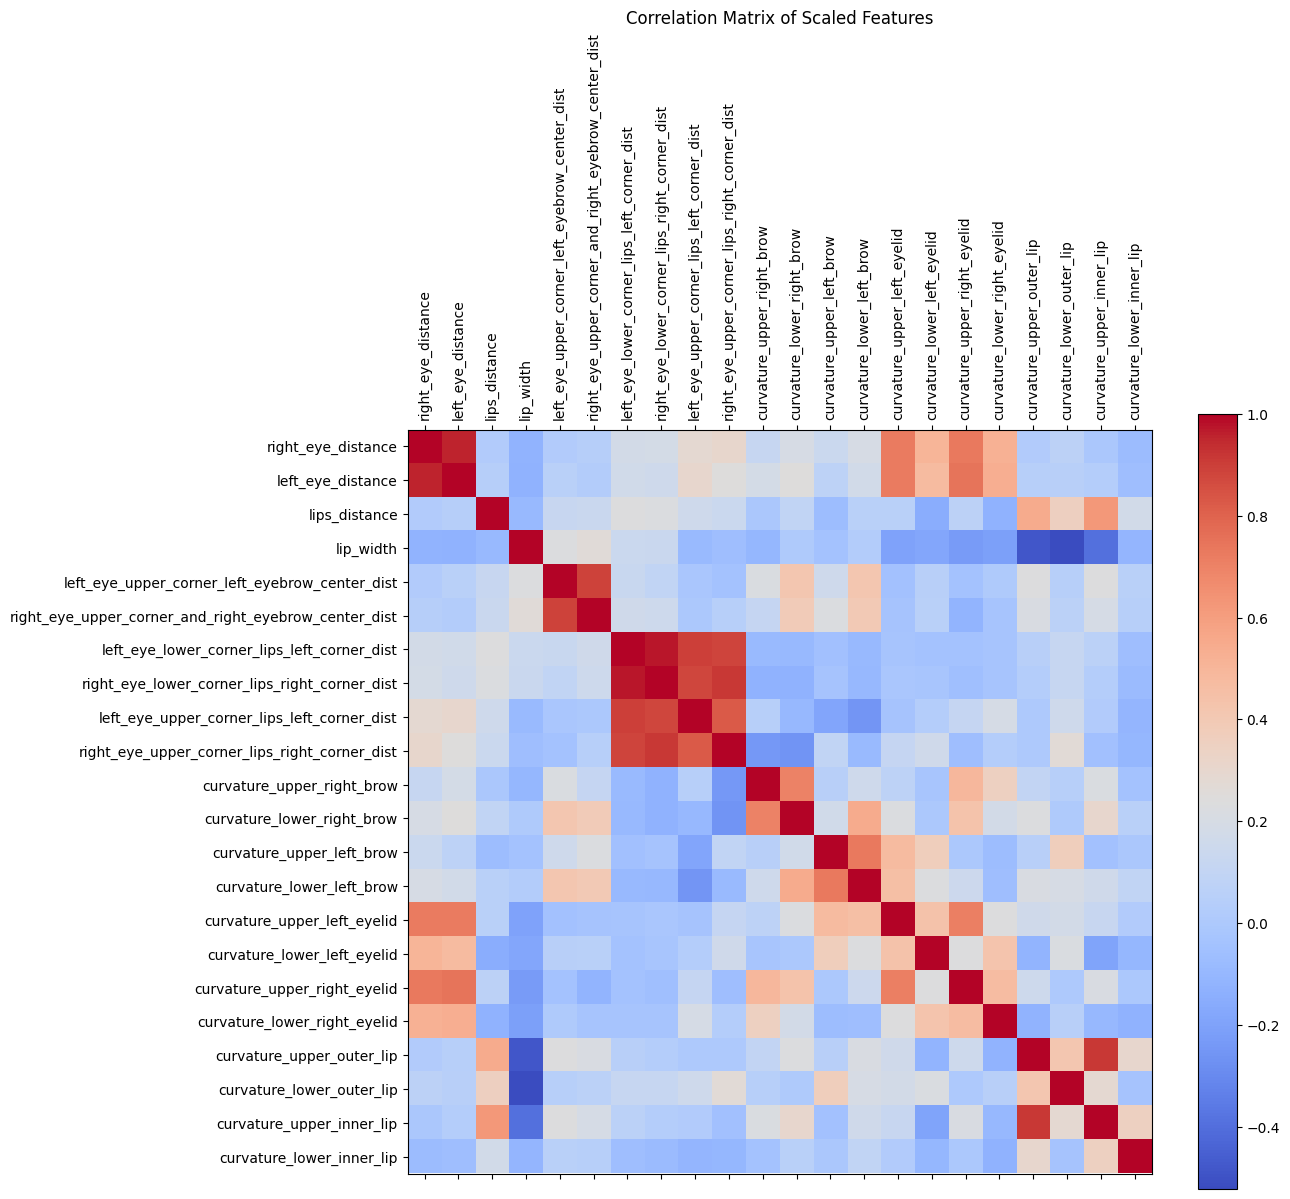

In [10]:
correlation_matrix = np.corrcoef(features_scaled.values, rowvar=False)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
plt.matshow(correlation_matrix, interpolation='nearest', cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(features_scaled.columns)), features_scaled.columns, rotation=90)
plt.yticks(range(len(features_scaled.columns)), features_scaled.columns)
plt.title('Correlation Matrix of Scaled Features')
plt.show()

In [11]:
# data.drop(columns=['left_eye_upper_corner_left_eyebrow_center_dist','left_eye_distance'], inplace=True)
# features.drop(columns=['left_eye_upper_corner_left_eyebrow_center_dist','left_eye_distance'], inplace=True)
# features_scaled.drop(columns=['left_eye_upper_corner_left_eyebrow_center_dist','left_eye_distance'], inplace=True)

# data.drop(columns=['left_eye_lower_corner_lips_left_corner_dist', 'right_eye_lower_corner_lips_right_corner_dist', 'left_eye_upper_corner_lips_left_corner_dist', 'right_eye_upper_corner_and_right_eyebrow_center_dist', 'right_eye_upper_corner_lips_right_corner_dist'], inplace=True)
# features.drop(columns=['left_eye_lower_corner_lips_left_corner_dist', 'right_eye_lower_corner_lips_right_corner_dist', 'left_eye_upper_corner_lips_left_corner_dist', 'right_eye_upper_corner_and_right_eyebrow_center_dist', 'right_eye_upper_corner_lips_right_corner_dist'], inplace=True)
# features_scaled.drop(columns=['left_eye_lower_corner_lips_left_corner_dist', 'right_eye_lower_corner_lips_right_corner_dist', 'left_eye_upper_corner_lips_left_corner_dist', 'right_eye_upper_corner_and_right_eyebrow_center_dist', 'right_eye_upper_corner_lips_right_corner_dist'], inplace=True)

# data.drop(columns=['lips_distance', 'lip_width', 'right_eye_distance' ], inplace = True)
# features.drop(columns=['lips_distance', 'lip_width', 'right_eye_distance' ], inplace = True)
# features_scaled.drop(columns=['lips_distance', 'lip_width', 'right_eye_distance' ], inplace = True)

In [12]:
feature_pairs = [
    ('curvature_upper_left_brow','curvature_lower_left_brow','curvature_left_brow'),
    ('curvature_upper_right_brow','curvature_lower_right_brow','curvature_right_brow'),
    # ('right_brow_mean_y', 'left_brow_mean_y', 'brow_mean_y'),
    ('right_eye_distance', 'left_eye_distance', 'eyelid_distance'),
    #('curvature_left_brow','curvature_right_brow','curvature_brows'),
    ('right_eye_lower_corner_lips_right_corner_dist', 'left_eye_lower_corner_lips_left_corner_dist', 'eye_lower_corner_lips_corner_dist'),
    ('left_eye_upper_corner_left_eyebrow_center_dist', 'right_eye_upper_corner_and_right_eyebrow_center_dist', 'eye_upper_corner_eyebrow_center_dist'),
    ('left_eye_upper_corner_lips_left_corner_dist','right_eye_upper_corner_lips_right_corner_dist','eye_upper_corner_lips_corner_dist'),
    #('curvature_upper_left_eyelid', 'curvature_upper_right_eyelid', 'curvature_upper_eyelid'),
    #('curvature_lower_left_eyelid', 'curvature_lower_right_eyelid', 'curvature_lower_eyelid'),
    #('eye_lower_corner_lips_corner_dist','eye_upper_corner_lips_corner_dist','eye_lips_corner_dist')
]

# Calculate mean for each pair and add to dataframes
for col1, col2, new_col in feature_pairs:
    data[new_col] = data[[col1, col2]].mean(axis=1)
    features[new_col] = features[[col1, col2]].mean(axis=1)
    features_scaled[new_col] = features_scaled[[col1, col2]].mean(axis=1)

# Drop the old columns from dataframes
cols_to_drop = [col for pair in feature_pairs for col in pair[:2]]
data.drop(columns=cols_to_drop, inplace=True)
features.drop(columns=cols_to_drop, inplace=True)
features_scaled.drop(columns=cols_to_drop, inplace=True)

In [13]:
data.drop(columns=['eye_upper_corner_lips_corner_dist','curvature_upper_inner_lip'], inplace=True)
features.drop(columns=['eye_upper_corner_lips_corner_dist','curvature_upper_inner_lip'], inplace=True)
features_scaled.drop(columns=['eye_upper_corner_lips_corner_dist','curvature_upper_inner_lip'], inplace=True)

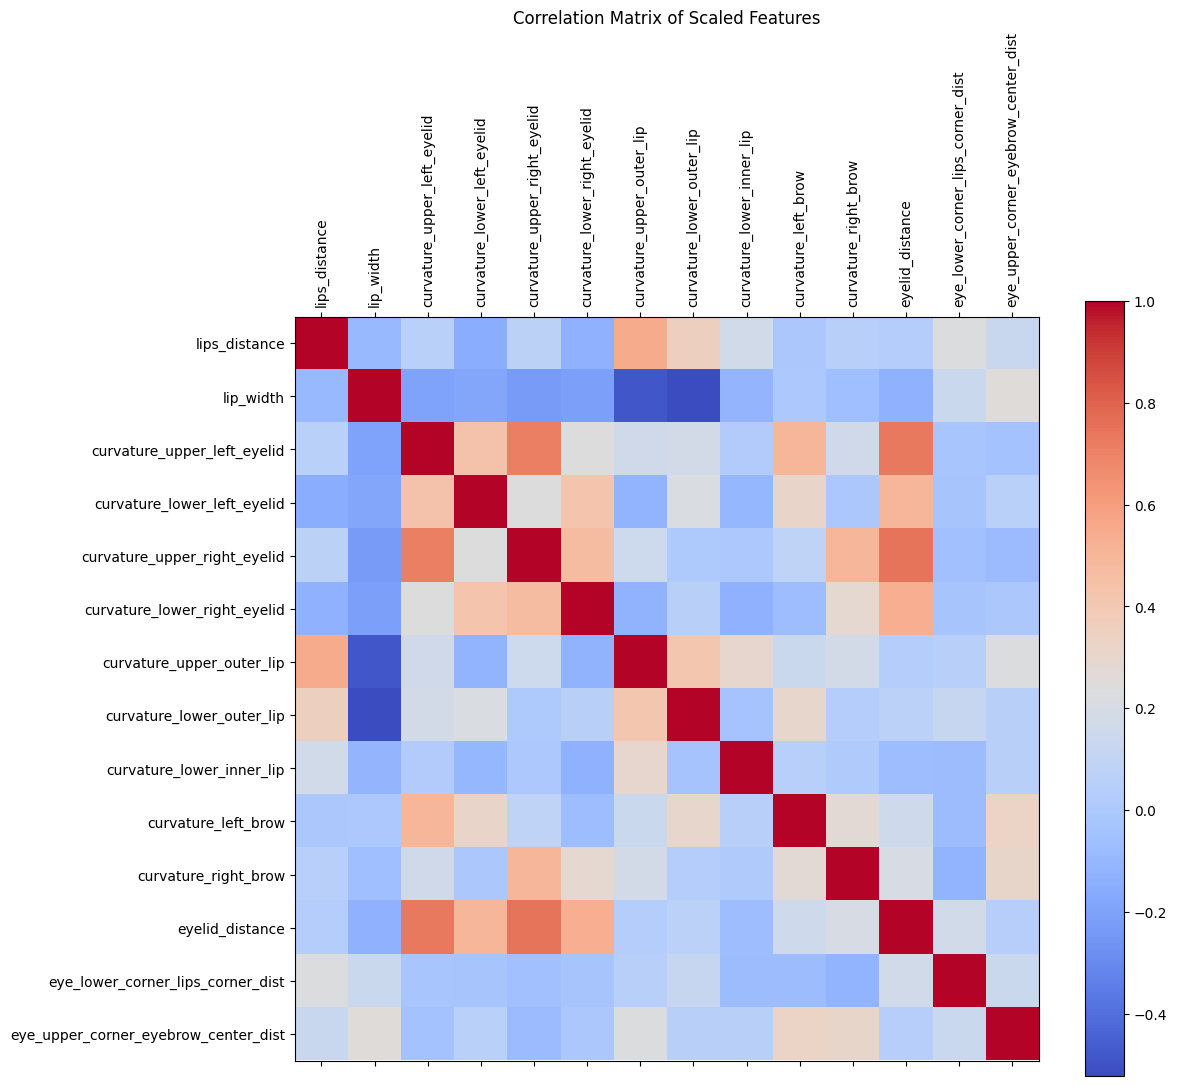

In [14]:
correlation_matrix = np.corrcoef(features_scaled.values, rowvar=False)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
plt.matshow(correlation_matrix, interpolation='nearest', cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(features_scaled.columns)), features_scaled.columns, rotation=90)
plt.yticks(range(len(features_scaled.columns)), features_scaled.columns)
plt.title('Correlation Matrix of Scaled Features')
plt.show()

In [15]:
# apply PCA to the standardized data
pca = PCA(n_components=0.90)  # Retain 95% of variance
principal_components = pca.fit_transform(features_scaled)

# number of components selected
n_components = pca.n_components_
print(f'Number of components selected: {n_components}')

Number of components selected: 9


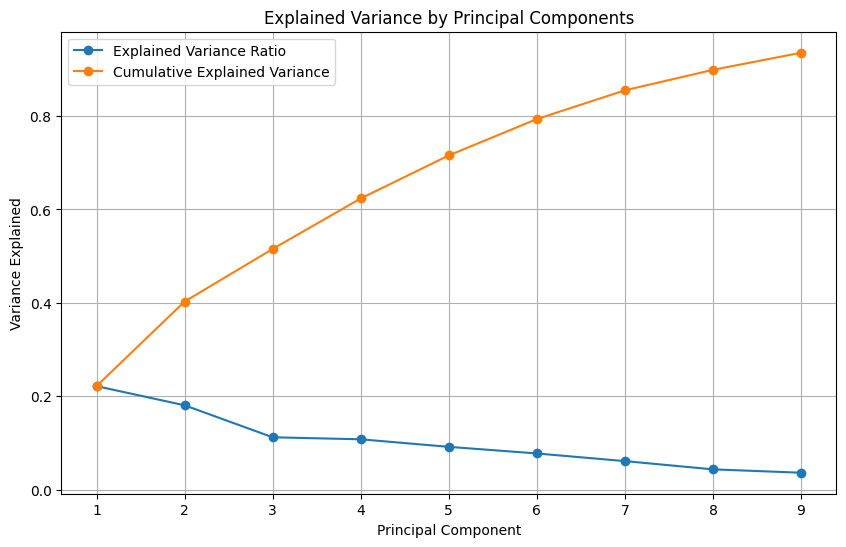

In [16]:
# explained variance ratio and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Explained Variance Ratio')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid(True)
plt.show()

# K-Means

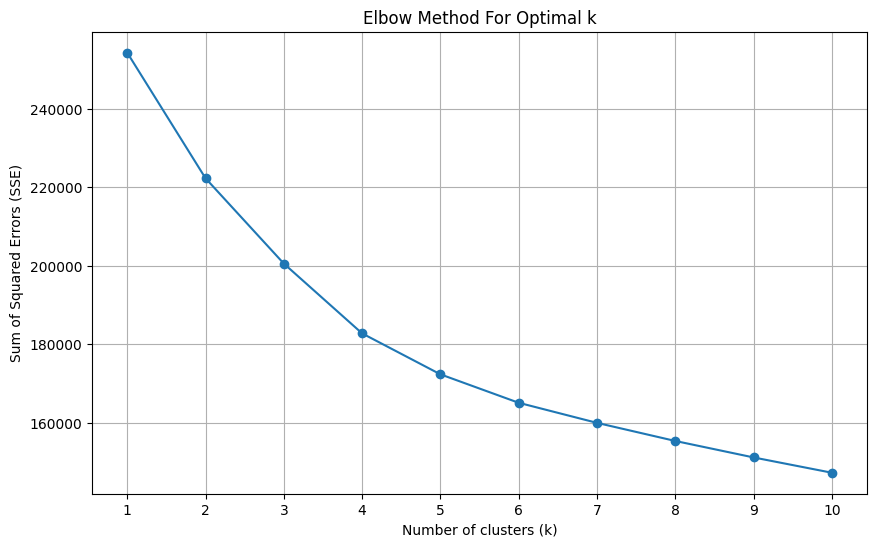

In [96]:
from joblib import Parallel, delayed
def compute_sse(k):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=30)
    kmeans.fit(features_scaled)
    return kmeans.inertia_

# Define the range of k
k_range = range(1, 11)

# Calculate SSE in parallel using all available cores
sse = Parallel(n_jobs=8)(delayed(compute_sse)(k) for k in k_range)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [17]:
optimal_k = 8  # choose based on your elbow plot

# K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=120)
data['cluster'] = kmeans.fit_predict(principal_components)

features_scaled['cluster'] = data['cluster']
grouped_data = data.drop(columns=['infant_id', 'frame_id', 'cam', 'date','age']).groupby('cluster').mean()
grouped_data_scaled = features_scaled.groupby('cluster').mean()
# analyze the clusters
print(grouped_data_scaled)

         lips_distance  lip_width  curvature_upper_left_eyelid  \
cluster                                                          
0             0.101350   0.516635                     0.650667   
1             0.114477   0.487574                     0.642998   
2             0.082864   0.500472                     0.578718   
3             0.215316   0.338805                     0.695556   
4             0.129317   0.574046                     0.675041   
5             0.528533   0.533070                     0.591780   
6             0.151311   0.559346                     0.314007   
7             0.542167   0.368294                     0.672562   

         curvature_lower_left_eyelid  curvature_upper_right_eyelid  \
cluster                                                              
0                           0.547078                      0.719492   
1                           0.471197                      0.638984   
2                           0.527179                      0

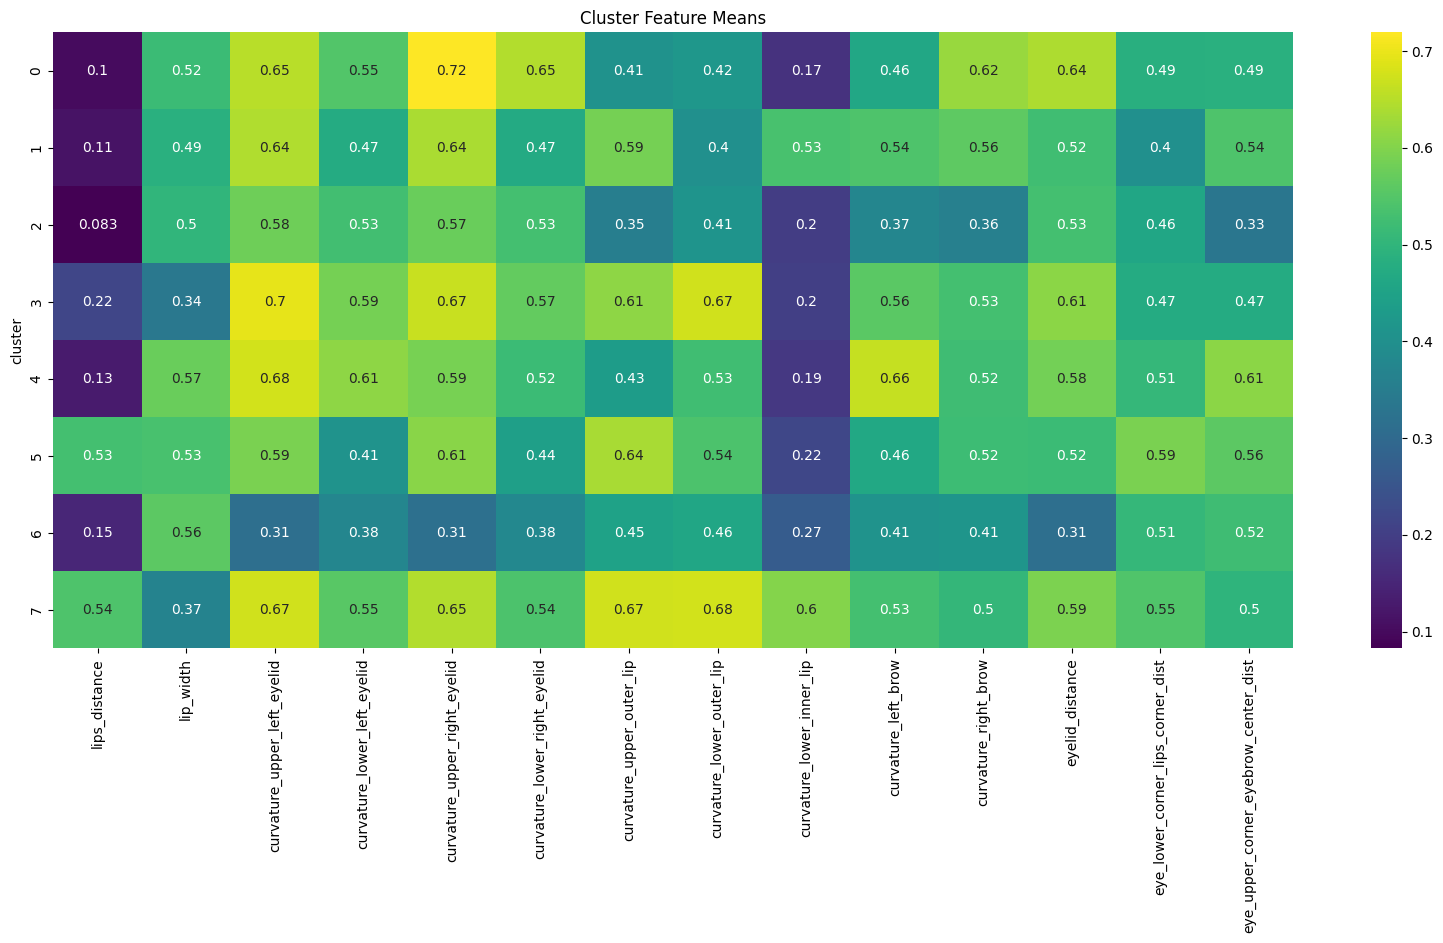

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap to visualize the average feature values for each cluster
plt.figure(figsize=(20, 8))
sns.heatmap(grouped_data_scaled, annot=True, cmap='viridis')
plt.title('Cluster Feature Means')
plt.show()


In [99]:
emotion_counts = data['cluster'].value_counts()
print(emotion_counts)

3    139800
0    126193
2     97440
1     88095
Name: cluster, dtype: int64


In [22]:
# mapping from clusters to emotion labels
cluster_to_emotion = {
    0: 'Neutal',
    1: 'Negative',
    2: 'Positive',
   # 3: 'Positive-Neutral',
   # 4: 'Neutral',
}


data['cluster'] = data['cluster'].map(cluster_to_emotion)
# data.drop(columns=['cluster'], inplace=True)

# resulting DataFrame
print(data.head())

   infant_id     date  cam  frame_id  right_brow_mean_y  left_brow_mean_y  \
0       28.0  19233.0  3.0     347.0           0.905686          0.803035   
1       28.0  19233.0  3.0     348.0           0.903004          0.836149   
2       28.0  19233.0  3.0     349.0           0.904887          0.837346   
3       28.0  19233.0  3.0     350.0           0.578312          0.522265   
4       28.0  19233.0  3.0     351.0           0.901760          0.843465   

   right_eye_distance  left_eye_distance  lips_distance  left_eye_width  ...  \
0            0.177924           0.191596       0.009135        0.533945  ...   
1            0.180817           0.192653       0.008637        0.519658  ...   
2            0.183571           0.193279       0.010832        0.527845  ...   
3            0.175088           0.183976       0.008589        0.507032  ...   
4            0.175058           0.185739       0.012644        0.506678  ...   

   curvature_upper_left_brow  curvature_lower_left_brow 

        right_eye_distance           left_eye_distance            \
                      mean       std              mean       std   
cluster                                                            
0                -1.753179  0.799113         -1.743554  0.786874   
1                 0.499852  0.714127          0.334047  0.631060   
2                 0.470811  0.668543          0.671912  0.758758   
3                 0.161879  0.724091          0.136109  0.722525   
4                 0.016628  0.608271          0.020454  0.589567   

        lips_distance           lip_width            \
                 mean       std      mean       std   
cluster                                               
0            0.036042  1.108911  0.538925  1.147487   
1            0.308078  1.113844 -0.112272  0.997140   
2            0.282937  1.126270 -0.175542  0.934775   
3           -0.376148  0.684985 -0.121283  0.911184   
4           -0.212228  0.759970  0.036603  0.928925   

        left_e

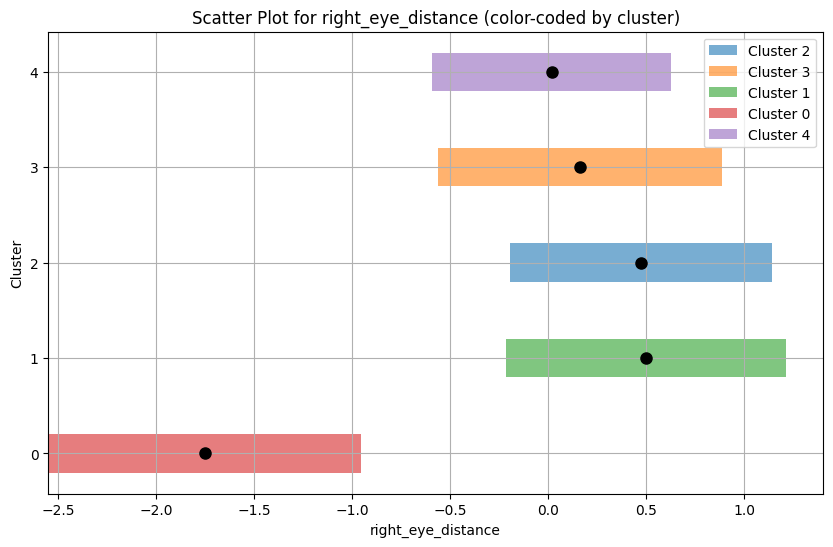

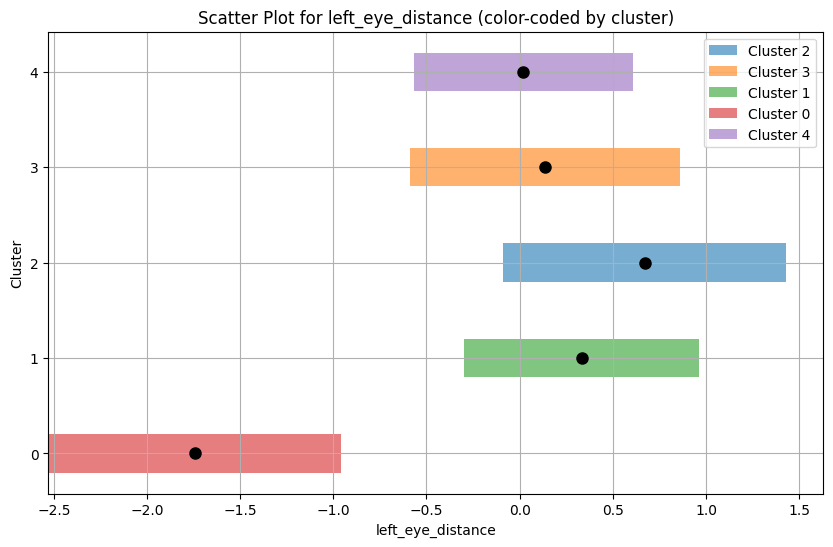

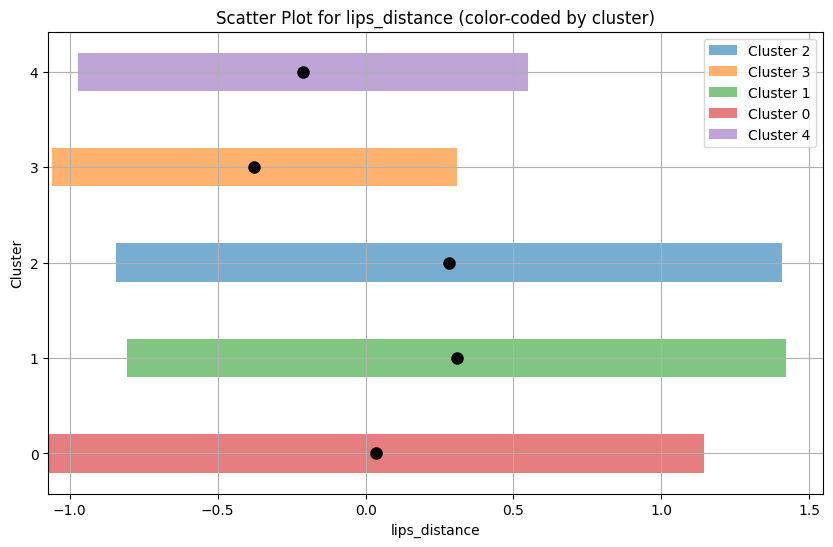

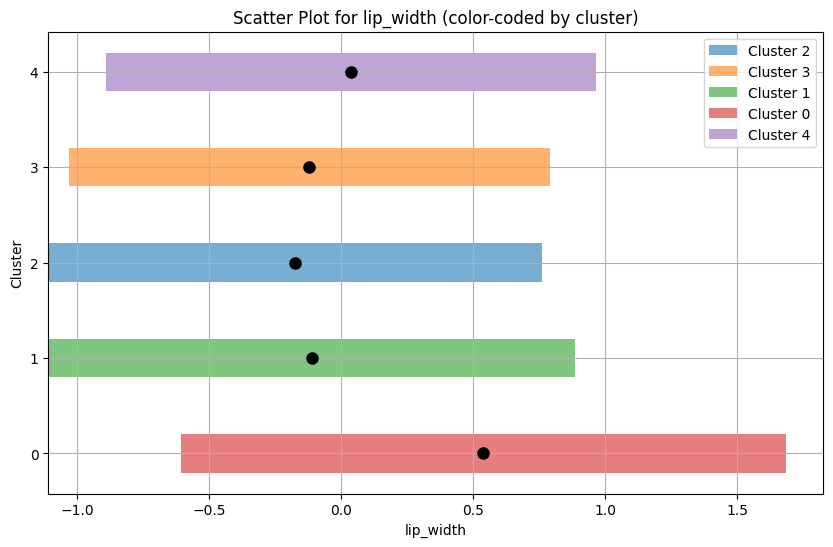

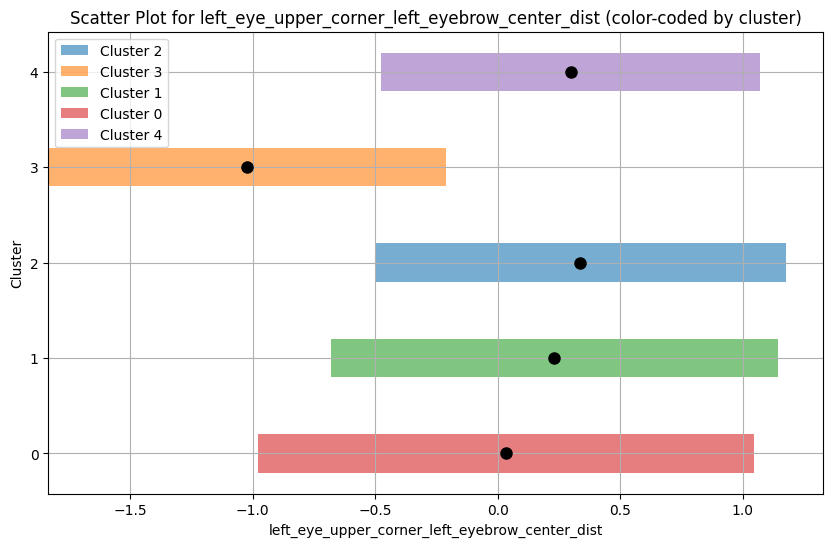

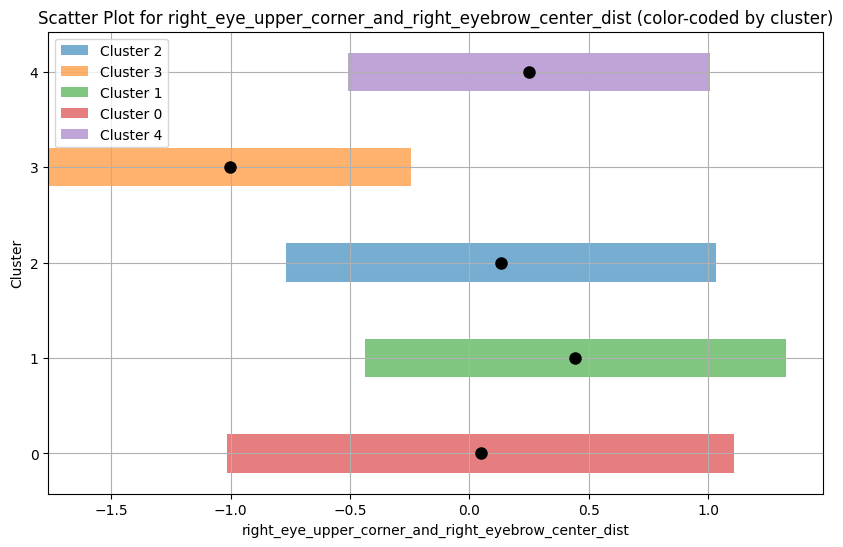

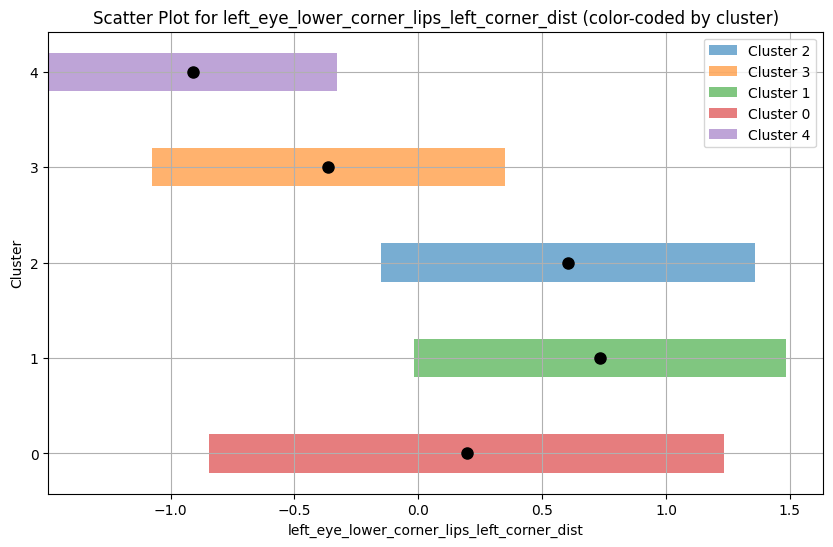

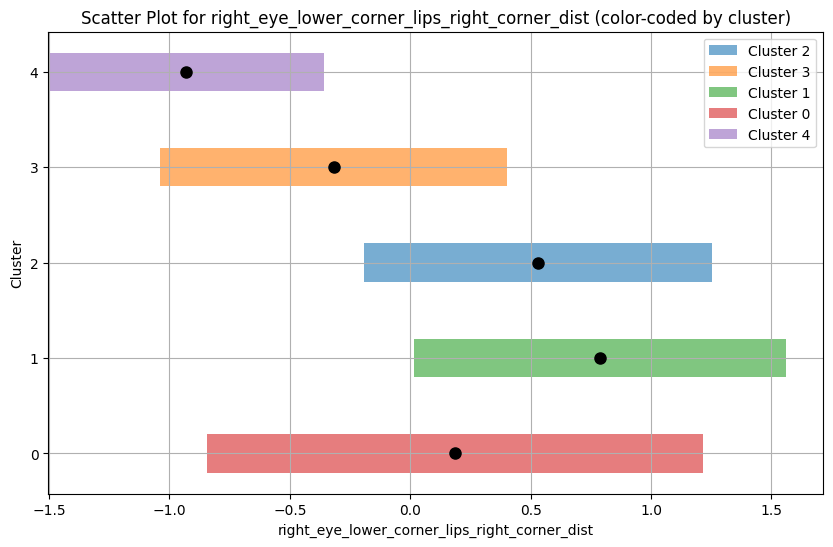

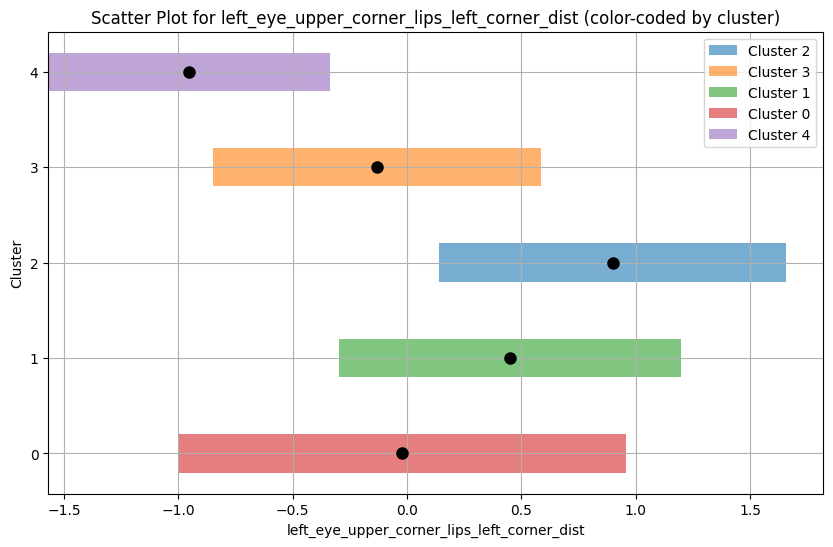

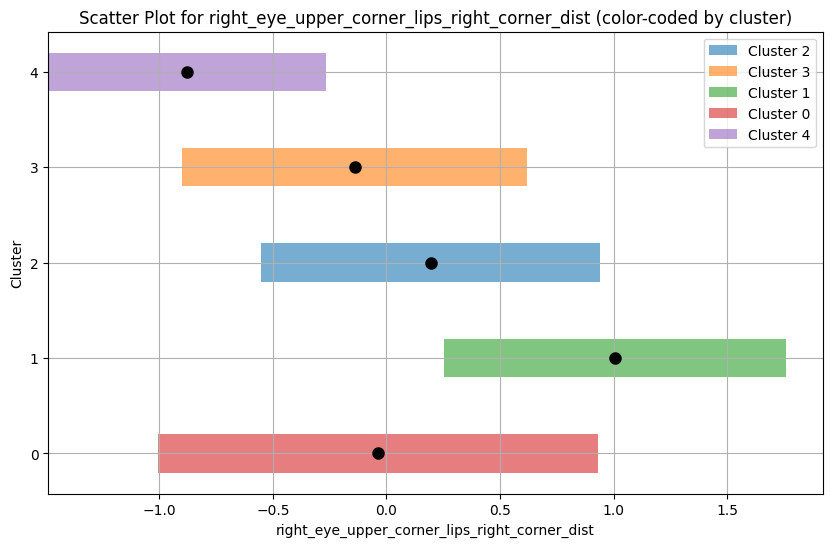

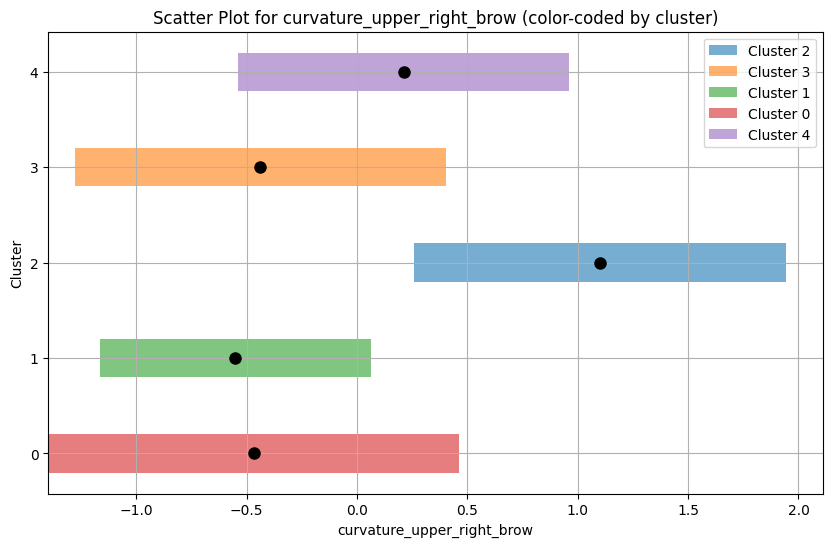

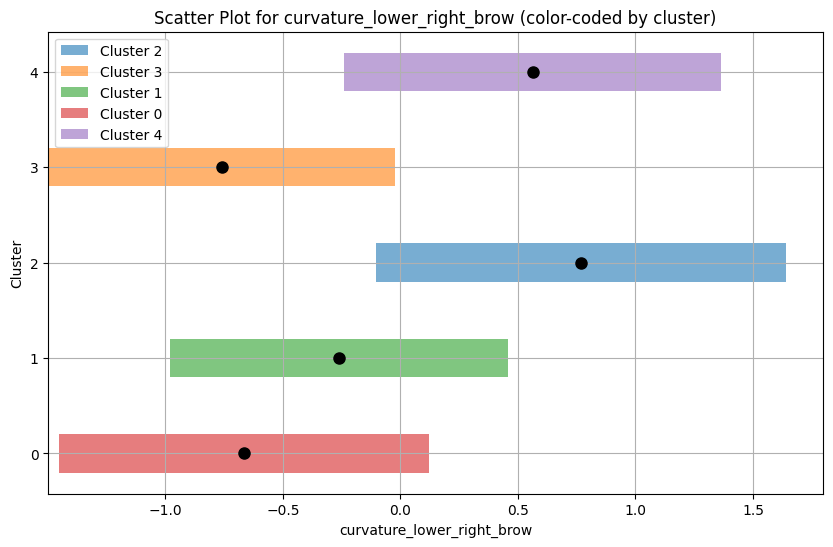

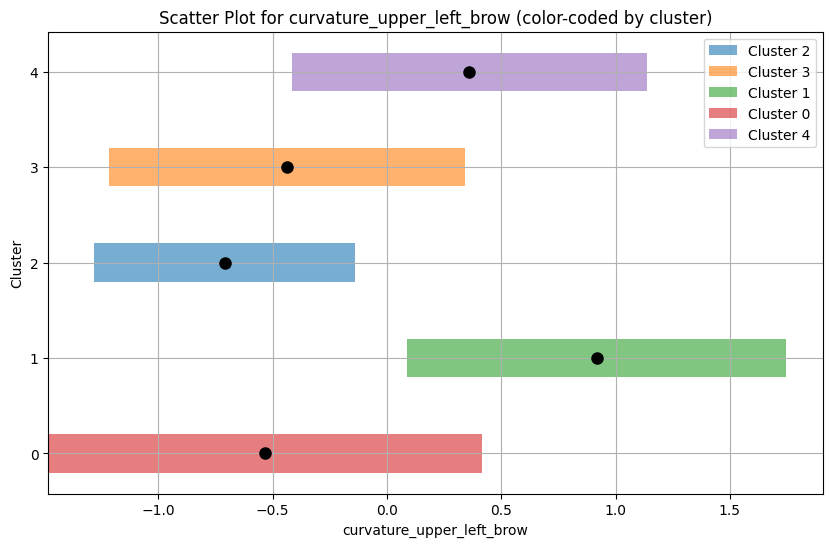

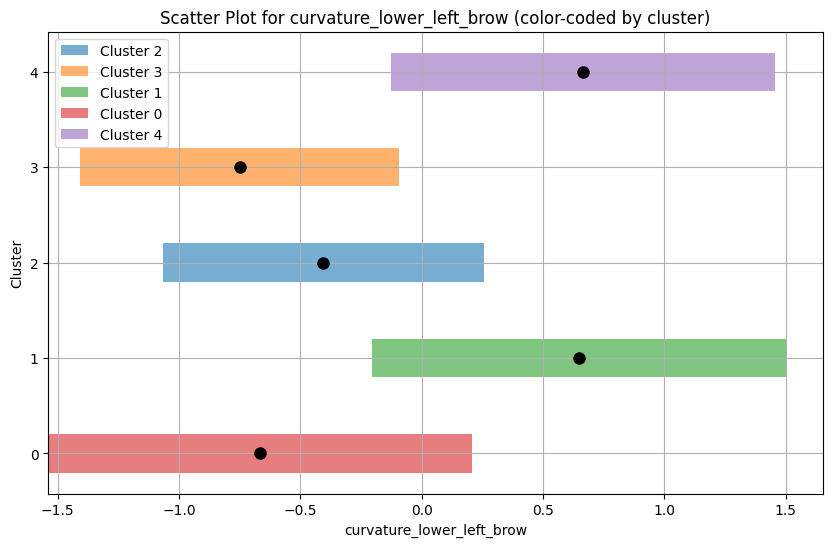

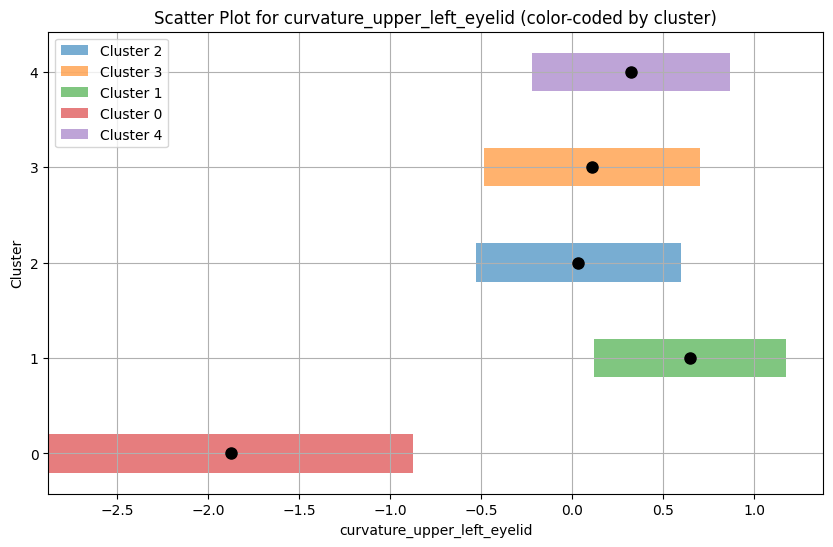

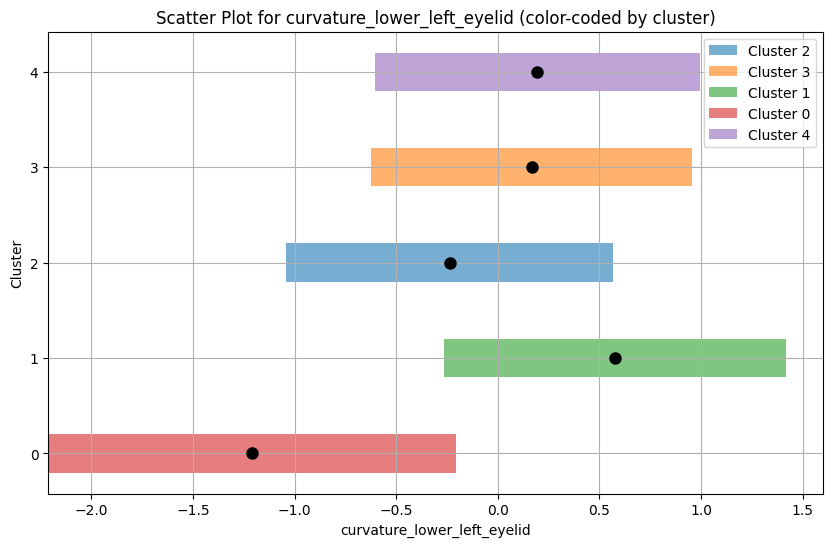

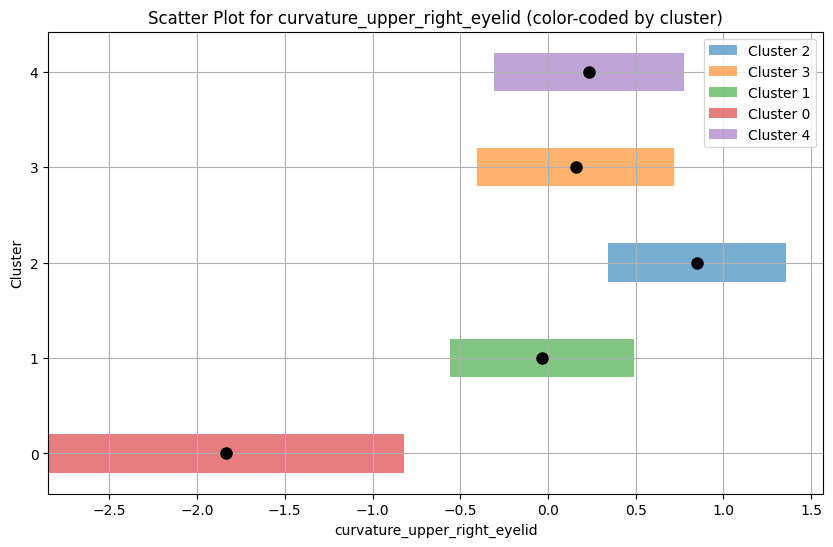

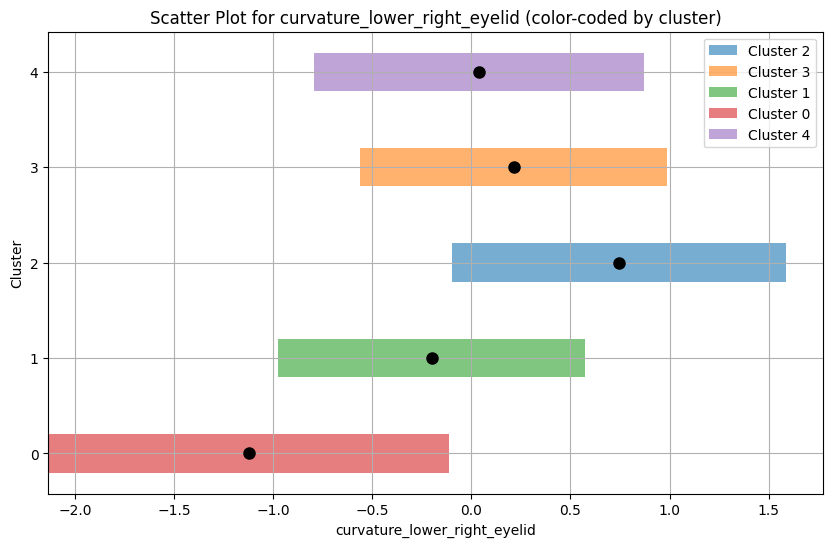

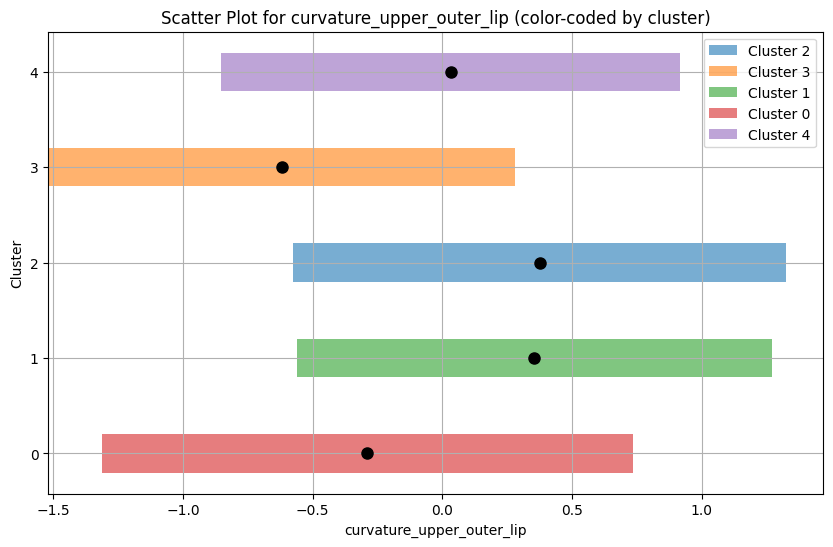

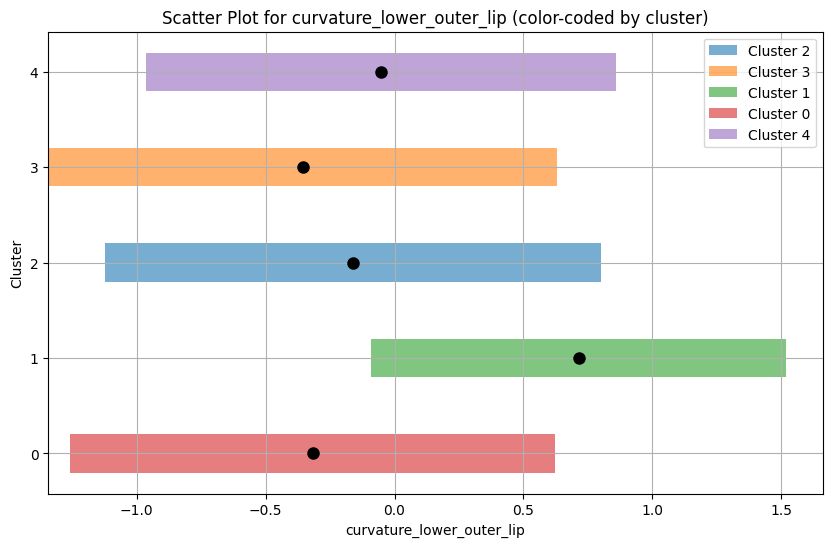

In [57]:
cluster_stats = features_scaled.groupby('cluster').agg(['mean', 'std'])

# Print cluster statistics
print(cluster_stats)

# Scatter plots for each feature
for feature in features_scaled.columns:
    if feature not in ['cluster', 'frame_id']:
        plt.figure(figsize=(10, 6))
        for cluster in data['cluster'].unique():
            mean_val = cluster_stats.loc[cluster, (feature, 'mean')]
            std_val = cluster_stats.loc[cluster, (feature, 'std')]
            
            # Create a horizontal bar for the mean and standard deviation
            plt.barh(cluster, 2 * std_val, left=mean_val - std_val, height=0.4, alpha=0.6, label=f'Cluster {cluster}')
            plt.plot(mean_val, cluster, 'o', markersize=8, color='black')  # Mark the mean
            
        plt.xlabel(feature)
        plt.ylabel('Cluster')
        plt.title(f'Scatter Plot for {feature} (color-coded by cluster)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Visualizer

In [24]:
import cv2
selected_columns = ["infant_id", "frame_id","date","cam","cluster"]
data_vis = data[selected_columns]
data_vis.dropna(inplace = True)
data_vis.reset_index(inplace = True)

/tmp/ipykernel_19578/577687420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_vis.dropna(inplace = True)


In [25]:
def process_infant_id(infant_id):
    infant_id_str = str(int(infant_id))
    if len(infant_id_str) == 1:
        return '00' + infant_id_str
    elif len(infant_id_str) == 2:
        return '0' + infant_id_str
    else:
        return infant_id_str[-3:]

# Function to get the frame from the video
def get_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Failed to extract frame {frame_number} from {video_path}")
        return None
    
# function to display a selected row
def display_row_panda_1_3(row_index, video_folder):
    if row_index < 0 or row_index >= len(data_vis):
        print("Invalid row index")
        return
    
    row = data_vis.iloc[row_index]
    infant_id = process_infant_id(row['infant_id'])
    frame_id = int(row['frame_id'])
    date_id = pd.to_datetime(row['date'], unit='D')
    date_id = date_id.strftime('%Y_%m_%d')
    emotion = row['cluster']
    cam_id = int(row['cam'])
    
    # video file path
    video_filename = f'r_{date_id}_833180_{infant_id}_cam{cam_id}_vid4.mp4'
    print(video_filename)
    print(emotion)
    video_path = f'{video_folder}/{video_filename}'
    
    # get the frame
    frame = get_frame(video_path, frame_id)
    
    if frame is not None:
        plt.figure(figsize=(10, 6))
        plt.imshow(frame)
        plt.title(f'Emotion: {emotion}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Frame {frame_id} could not be retrieved from {video_filename}")

r_2022_08_30_833180_033_cam3_vid4.mp4
Neutal


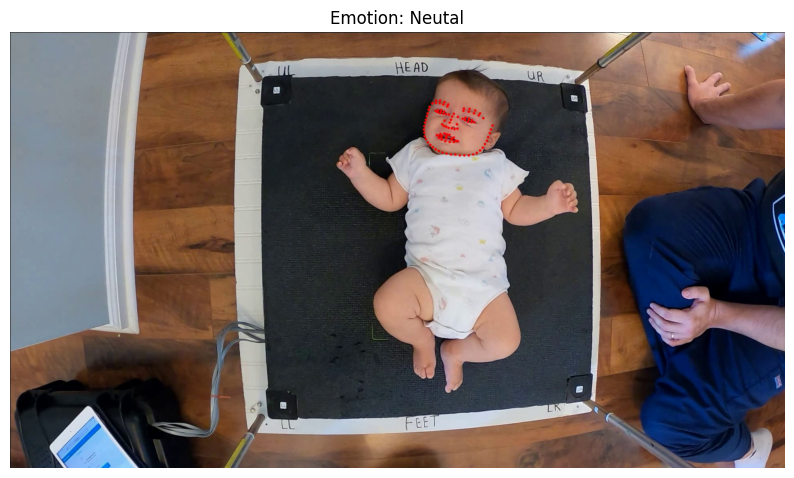

In [34]:
video_folder_panda_1 = '/workspaces/wiggle-face/data-ioana/PANDA1/r_face_infant_visible/vis'
video_folder_panda_3 = '/workspaces/wiggle-face/data-ioana/PANDA3/face/vis'
display_row_panda_1_3(9000, video_folder_panda_1)

In [ ]:
data

In [ ]:
data.to_csv('K_Means_Results_All_Data_updated', index=False)

# Aligned Cluster Analysis

In [19]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
import tqdm

/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [20]:
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(features)

In [ ]:
# Determine the optimal number of clusters using the elbow method and silhouette score
sse = []
silhouette_scores = []
k_range = range(2, 11)  # 2 clusters to a maximum of 10

for k in k_range:
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42)
    labels = model.fit_predict(data_scaled)
    sse.append(model.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled.reshape(data_scaled.shape[0], -1), labels))

# Plotting the elbow method
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o', label='SSE')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.legend()
plt.show()

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method For Optimal k')
plt.grid(True)
plt.legend()
plt.show()

In [21]:
from joblib import Parallel, delayed
n_clusters = 5  # Adjust as needed

# Define a function to perform clustering on a subset of data
def cluster_subset(data_subset):
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
    return model.fit_predict(data_subset), model.cluster_centers_

# Split data into chunks and use parallel processing
n_chunks = 12  # Adjust based on your system's capabilities
chunks = np.array_split(data_scaled, n_chunks)

# Perform clustering in parallel
results = Parallel(n_jobs=n_chunks)(delayed(cluster_subset)(chunk) for chunk in chunks)

# Combine results
labels = np.concatenate([result[0] for result in results])
cluster_centers = np.concatenate([result[1] for result in results])

# Plotting the clustered time series
plt.figure(figsize=(10, 6))
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, yi + 1)
    for xx in data_scaled[labels == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(cluster_centers[yi].ravel(), "r-", label=f'Cluster {yi+1} centroid')
    plt.title(f"Cluster {yi + 1}")
    plt.legend()

plt.tight_layout()
plt.show()

/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/tslearn/bases/bases.py:15:

KeyboardInterrupt: 

In [37]:
labels

array([2, 3, 2, ..., 3, 3, 3])

In [38]:
data['cluster'] = labels

In [39]:
data

,infant_id,date,cam,frame_id,lips_distance,lip_width,curvature_upper_right_brow,curvature_upper_outer_lip,curvature_lower_outer_lip,age,brow_mean_y,eyelid_distance,eye_upper_corner_eyebrow_center_dist,curvature_upper_eyelid,curvature_lower_eyelid,eye_lips_corner_dist,cluster
0,28.0,19233.0,3.0,1.0,0.027242,0.659271,2.204833,2.741163,1.870940,NaN,0.872507,0.175419,0.466915,2.854327,1.435084,1.139544,2
1,28.0,19233.0,3.0,2.0,0.023370,0.670994,2.201101,2.536125,1.799427,NaN,0.880292,0.179238,0.465458,2.860742,1.583417,1.142272,3
2,28.0,19233.0,3.0,3.0,0.023091,0.667702,2.130971,2.540535,2.039749,NaN,0.652029,0.179606,0.456767,2.833195,1.451493,1.150395,2
3,28.0,19233.0,3.0,4.0,0.018810,0.667445,2.231104,2.499023,1.892648,NaN,0.874143,0.183376,0.453111,2.817038,1.746262,1.154476,3
4,28.0,19233.0,3.0,5.0,0.021033,0.661650,2.287158,2.543107,1.938706,NaN,0.880480,0.180787,0.451747,2.835288,1.448036,1.148611,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120553,221.0,19381.0,3.0,5112.0,0.010281,0.848479,0.831783,1.317061,1.688648,NaN,0.422060,0.054457,0.394990,0.930354,0.521659,1.008646,3
1120554,221.0,19381.0,3.0,5113.0,0.012373,0.842983,0.918245,1.216497,1.974948,NaN,0.412807,0.048603,0.385749,0.865853,0.410260,0.994173,3
1120555,221.0,19381.0,3.0,5114.0,0.012133,0.855446,0.882186,1.167328,1.913136,NaN,0.406511,0.048232,0.374121,0.770244,0.539371,0.994049,3
1120556,221.0,19381.0,3.0,5115.0,0.007079,0.855597,1.014486,1.131441,2.202350,NaN,0.868072,0.045300,0.360401,0.684100,0.544091,0.981262,3


In [40]:
emotion_counts = data['cluster'].value_counts()
print(emotion_counts)

1    259109
0    254674
2    250604
4    187086
3    169085
Name: cluster, dtype: int64


            infant_id                        date              cam       \
                 mean           std          mean         std mean  std   
cluster                                                                   
0        10679.957131  23037.130369  19328.083585  235.377532  3.0  0.0   
1         7319.390715  18737.033843  19280.546745  276.451012  3.0  0.0   
2         7977.646079  19186.291916  19272.797603  237.355637  3.0  0.0   
3         8976.791198  20848.580284  19297.417424  270.476002  3.0  0.0   
4        10796.546303  22814.004269  19262.314580  261.144302  3.0  0.0   

            frame_id              lips_distance            ...  \
                mean          std          mean       std  ...   
cluster                                                    ...   
0        2018.905908  1604.905445      0.041132  0.035875  ...   
1        2341.583341  1847.393048      0.039903  0.039319  ...   
2        2201.952941  1733.417083      0.036669  0.035807  ...   
3  

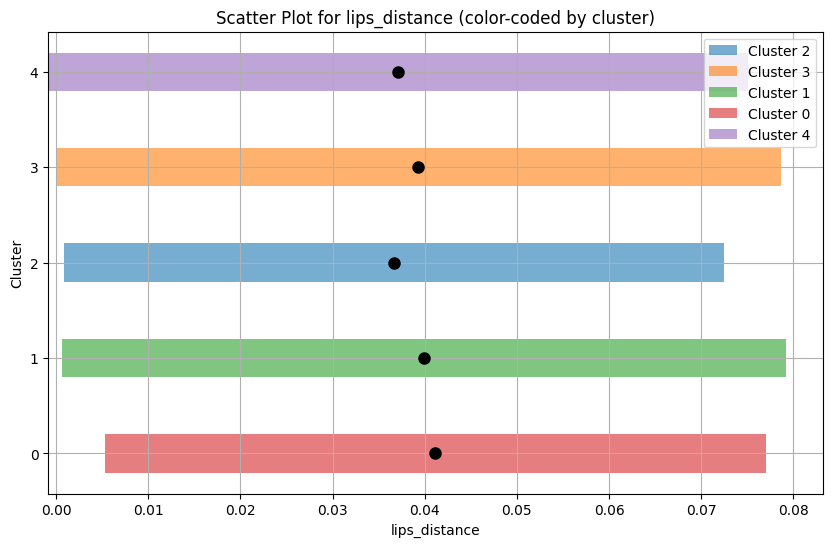

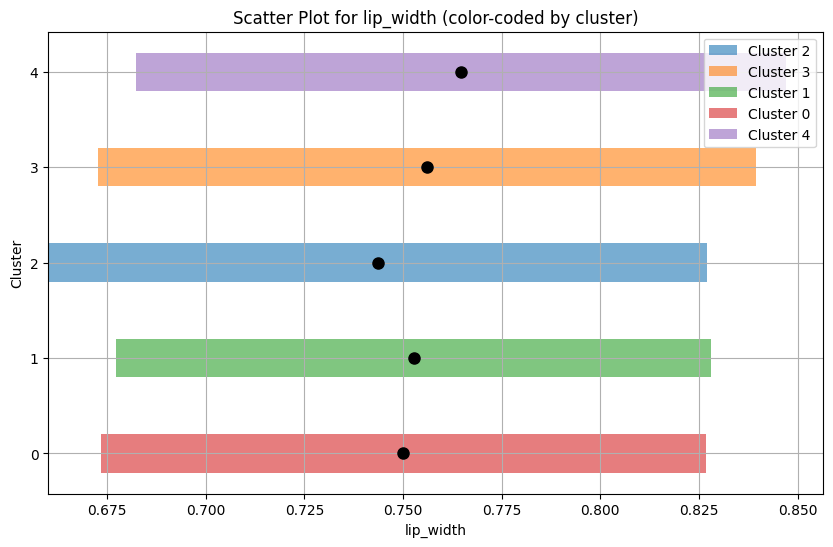

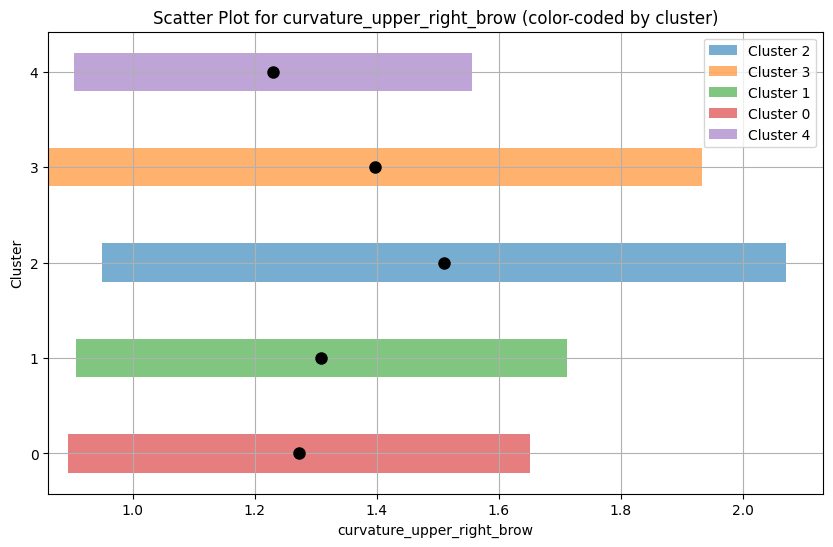

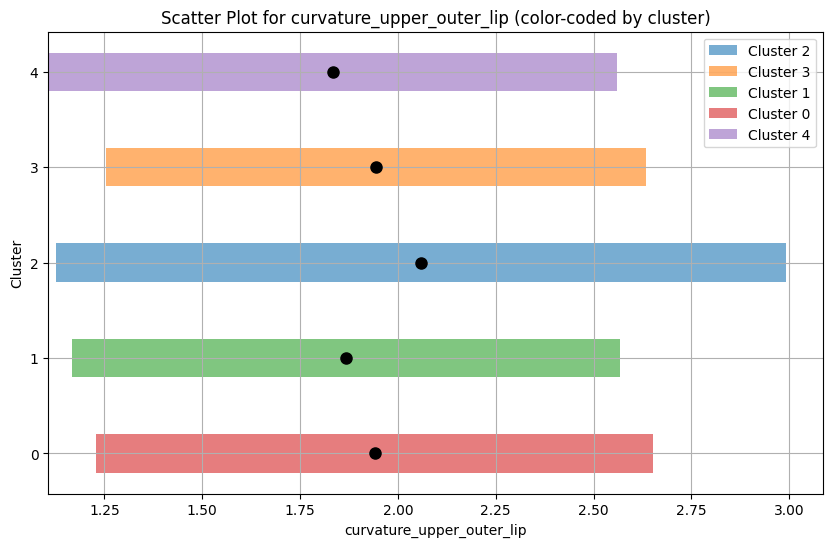

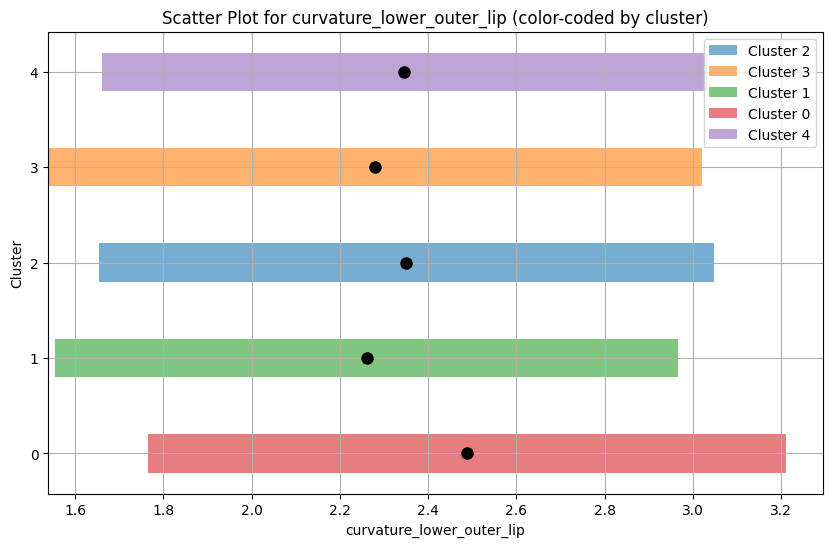

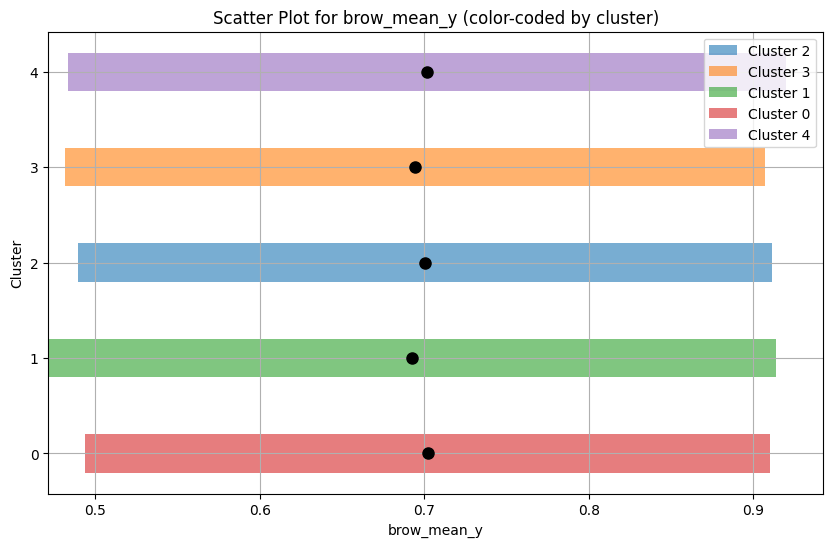

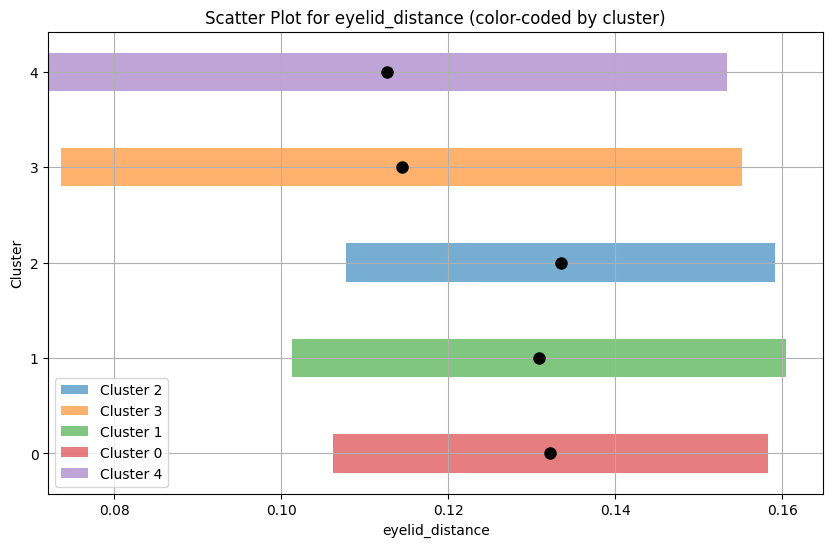

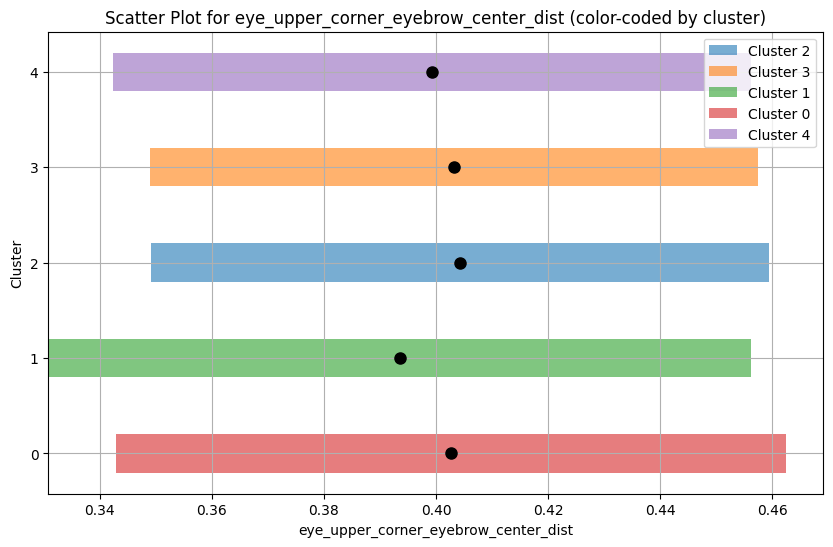

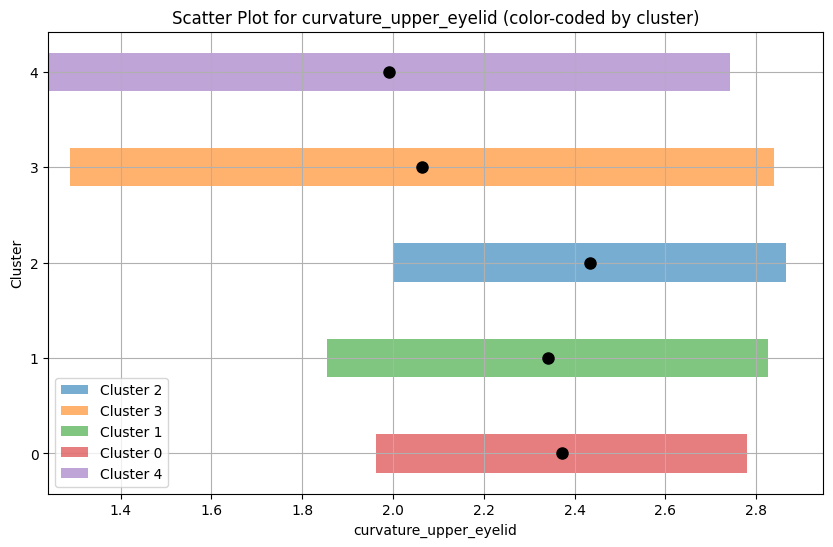

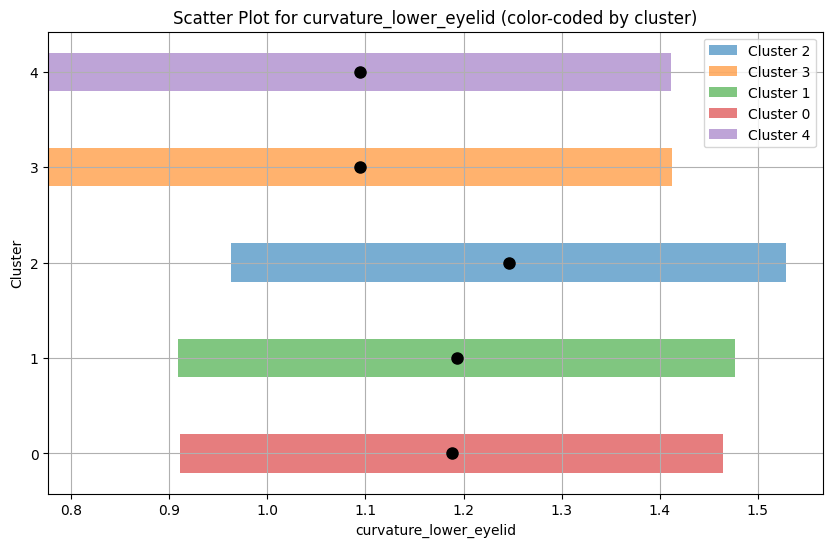

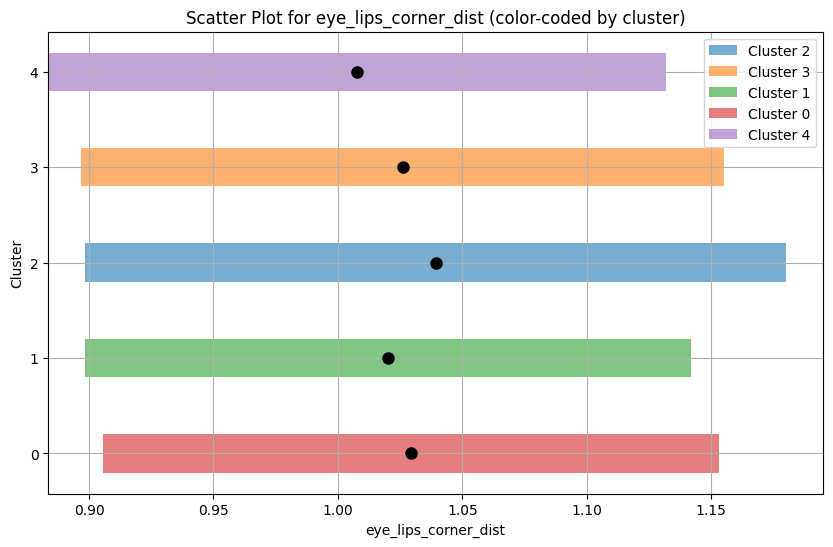

In [46]:
cluster_stats = data.groupby('cluster').agg(['mean', 'std'])

# Print cluster statistics
print(cluster_stats)

# Scatter plots for each feature
for feature in data.columns:
    if feature not in ['cluster', 'frame_id','infant_id','date','cam','age']:
        plt.figure(figsize=(10, 6))
        for cluster in data['cluster'].unique():
            mean_val = cluster_stats.loc[cluster, (feature, 'mean')]
            std_val = cluster_stats.loc[cluster, (feature, 'std')]
            
            # Create a horizontal bar for the mean and standard deviation
            plt.barh(cluster, 2 * std_val, left=mean_val - std_val, height=0.4, alpha=0.6, label=f'Cluster {cluster}')
            plt.plot(mean_val, cluster, 'o', markersize=8, color='black')  # Mark the mean
            
        plt.xlabel(feature)
        plt.ylabel('Cluster')
        plt.title(f'Scatter Plot for {feature} (color-coded by cluster)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Hierahical Clustering

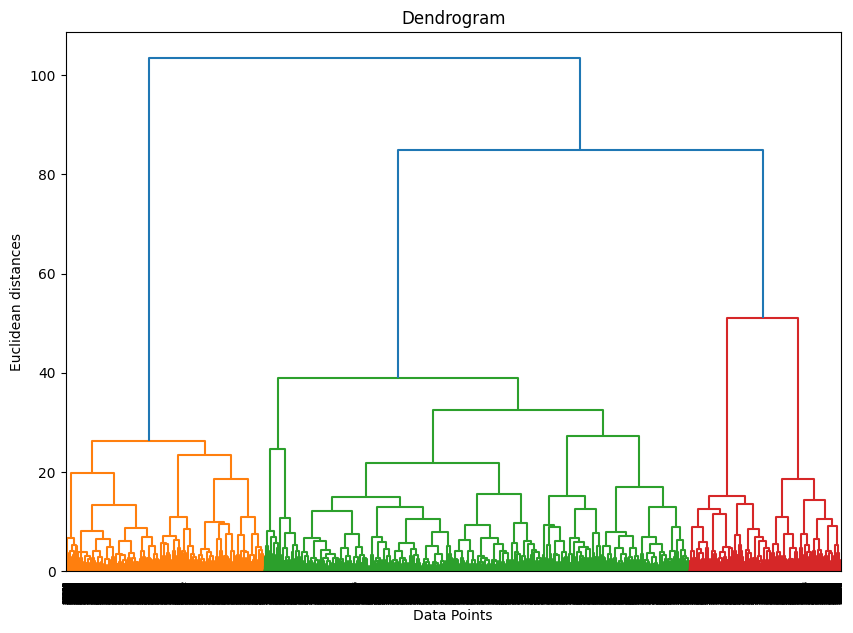

In [22]:
import scipy.cluster.hierarchy as sch

nan_count = np.isnan(principal_components).sum()
if nan_count > 0:
    print(f"Data contains {nan_count} NaN values. Please handle them before clustering.")
else:
    sample_indices = np.random.choice(principal_components.shape[0], size=40000, replace=False)
    sampled_data = principal_components[sample_indices, :]

    # Plot the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram = sch.dendrogram(sch.linkage(sampled_data, method='ward'))
    plt.title('Dendrogram')
    plt.xlabel('Data Points')
    plt.ylabel('Euclidean distances')
    plt.show()